In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# get data from an API
import requests
import json

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from scipy.stats import shapiro
import pmdarima as pm
from scipy import stats
from scipy.special import inv_boxcox

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from sklearn.model_selection import train_test_split

# find root mean square error for the prophet model
from sklearn.metrics import mean_squared_error
from math import sqrt


In [5]:
# get data from the api url
url = r'https://api.eia.gov/v2/electricity/rto/region-sub-ba-data/data/?frequency=hourly&data[0]=value&facets[parent][]=ERCO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key=OnfTQ00ROLCCmUPP1n5IrvWJcom60KghdbxUKS7x'

In [221]:
url = r'https://api.eia.gov/v2/electricity/rto/daily-region-sub-ba-data/data/?frequency=daily&data[0]=value&facets[subba][]=NCEN&facets[parent][]=ERCO&facets[timezone][]=Central&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000&api_key=OnfTQ00ROLCCmUPP1n5IrvWJcom60KghdbxUKS7x'

In [222]:
# using the get method to get the data using the url and the header
response = requests.get(url)
# convert the response to json
data = response.json()
# print the data
# print(data)
# there is 'data' key in the json returned. extract the data and put it in a dataframe
df = pd.DataFrame(data['response']['data'])
print(df.head())

          period subba     subba-name parent  \
0  2019-05-27T06  NCEN  North Central   ERCO   
1  2019-05-27T07  NCEN  North Central   ERCO   
2  2019-05-27T08  NCEN  North Central   ERCO   
3  2019-05-27T09  NCEN  North Central   ERCO   
4  2019-05-27T10  NCEN  North Central   ERCO   

                                   parent-name  value    value-units  
0  Electric Reliability Council of Texas, Inc.  12432  megawatthours  
1  Electric Reliability Council of Texas, Inc.  11662  megawatthours  
2  Electric Reliability Council of Texas, Inc.  11164  megawatthours  
3  Electric Reliability Council of Texas, Inc.  10768  megawatthours  
4  Electric Reliability Council of Texas, Inc.  10565  megawatthours  


# Using the fetch data to get more data records

In [85]:
import fetch_data
df = fetch_data.fetch_all_data()
df = pd.DataFrame(df)
print(df.head())

       period subba     subba-name parent  \
0  2019-05-27  NCEN  North Central   ERCO   
1  2019-05-28  NCEN  North Central   ERCO   
2  2019-05-29  NCEN  North Central   ERCO   
3  2019-05-30  NCEN  North Central   ERCO   
4  2019-05-31  NCEN  North Central   ERCO   

                                   parent-name timezone   value    value-units  
0  Electric Reliability Council of Texas, Inc.  Central  339118  megawatthours  
1  Electric Reliability Council of Texas, Inc.  Central  344165  megawatthours  
2  Electric Reliability Council of Texas, Inc.  Central  327540  megawatthours  
3  Electric Reliability Council of Texas, Inc.  Central  321553  megawatthours  
4  Electric Reliability Council of Texas, Inc.  Central  312454  megawatthours  


In [228]:
df = pd.read_excel('electricity_data.xlsx')
df.head()

In [229]:
# only keep values in df where the subba = 'NCEN'
df = df[df['subba'] == 'NCEN']
final_df = df[['period', 'value']]

# I have a string for '2024-04-18T05' split that into the date and the time year column like '2024-04-18' and time '05'
final_df['date'] = final_df['period'].str.split('T').str[0]
final_df['time'] = final_df['period'].str.split('T').str[1]

# combine the date and time column
df['date_time'] = pd.to_datetime(final_df['date'] + ' ' + final_df['time'])

final_df.head(2)

,period,value,date,time
0,2019-05-27T06,12432,2019-05-27,06
1,2019-05-27T07,11662,2019-05-27,07


In [8]:
# # considering date and time column as the time period reference, develop an arima model to fit the values 

# # arima modeling
# # from statsmodels.tsa.arima_model import ARIMA
# # from statsmodels.tsa.stattools import adfuller
# import pmdarima as pm



# # Set 'date_time' as the index
# df.set_index('date_time', inplace=True)

# # Fit auto_arima function to dataset
# model = pm.auto_arima(df['value'], start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

In [97]:
df.head(2)
f_df = df[['period','value']]

In [10]:
adf_test = adfuller(f_df['value'])
adf_test

(-3.844900030166585,
 0.002479928114243233,
 15,
 1767,
 {'1%': -3.4340561828849263,
  '5%': -2.8631770735572126,
  '10%': -2.567641527843835},
 40784.45723170653)

Thus the data is stationary as the significance value is less tha 0.05.

In [98]:
## All the pre-processing
# Assuming f_df is your DataFrame and 'values' is the column you want to test
stat, p = shapiro(f_df['value'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')



f_df['value'] = pd.to_numeric(f_df['value'], errors='coerce')
# Assuming f_df is your DataFrame and 'values' is the column you want to transform to make the data normal with boxcox
# f_df['value'], lam = stats.boxcox(f_df['value'])

# print('Lambda: ', lam)

Statistics=0.924, p=0.000
Sample does not look Gaussian (reject H0)


In [12]:
# split the df into 70-30 % train and test split
train, test = f_df[0:int(len(df)*0.7)], f_df[int(len(f_df)*0.7):]

In [13]:
model = pm.auto_arima(train['value'], seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7400.253, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5671.230, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6789.829, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6224.676, Time=3.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1627.171, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7153.580, Time=5.75 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7394.188, Time=1.83 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7391.743, Time=2.06 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-7398.115, Time=10.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6935.172, Time=4.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7162.317, Time=4.46 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7370.454, Time=2.26 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-7395.704, Time=4.76 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7250.571, Time=2.80 sec

Best model:  ARIMA

## lower the aic score, better is the model fit in ARIMA

In [14]:
# generate a arima model on the train dataset with the order (2,1,0) and use that model to predict values in the tes data set
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA
'''
# The working part
# Fit the model
model = ARIMA(train['value'], order=(2,1,0))
model_fit = model.fit()

# # Forecast
# forecast, stderr, conf_int = model_fit.forecast(steps=len(test))
forecast = model_fit.forecast(steps=len(test))
# # Print the forecast
# print(forecast)
'''

# New addition where we get the confidence interval too
model = ARIMA(train['value'], order=(2,1,0))
model_fit = model.fit()

# forecast
forecast_results = model_fit.get_forecast(steps=len(test))

forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()


In [15]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  437
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3668.258
Date:                Fri, 26 Apr 2024   AIC                          -7330.515
Time:                        14:48:22   BIC                          -7318.282
Sample:                             0   HQIC                         -7325.688
                                - 437                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1412    3.1e-19   3.68e+18      0.000       1.141       1.141
ar.L2         -0.3883   7.29e-20  -5.33e+18      0.000      -0.388      -0.388
sigma2      2.865e-09   2.34e-10     12.218      0.000    2.41e-09    3.32e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.75
Prob(Q):                              0.97   Prob(JB):                         0.15
Heteroskedasticity (H):               1.25   Skew:                            -0.21
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.48e+34. Standard errors may be unstable.
"""

In [16]:
# Reset index in test DataFrame
test = test.reset_index(drop=True)

# Reset index in forecast Series
forecast = forecast.reset_index(drop=True)

# Reset index in confidence intervall
conf_int = conf_int.reset_index(drop=True)

In [17]:
test['pred'] = forecast
final_df = test.join(conf_int)
final_df.head()

,date_time,value,pred,lower value,upper value
0,2024-04-07 00:00:00,1.553718,1.553672,1.553567,1.553777
1,2024-04-06 23:00:00,1.553729,1.553645,1.553396,1.553893
2,2024-04-06 22:00:00,1.553687,1.553625,1.553219,1.554031
3,2024-04-06 21:00:00,1.553667,1.553613,1.553054,1.554171
4,2024-04-06 20:00:00,1.553666,1.553606,1.552909,1.554304


In [18]:
# Assuming f_df['value'] is your transformed data and lam is the lambda value used for the transformation
final_df['value'] = inv_boxcox(final_df['value'], lam)
final_df['pred'] = inv_boxcox(final_df['pred'], lam)

final_df['lower value'] = inv_boxcox(final_df['lower value'], lam)
final_df['upper value'] = inv_boxcox(final_df['upper value'], lam)

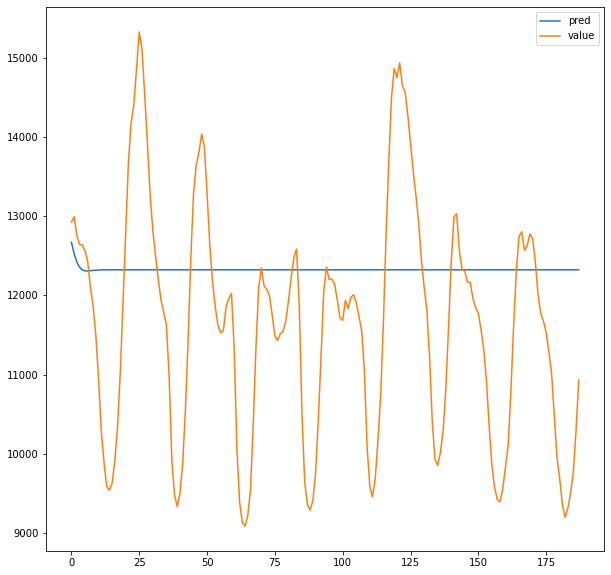

In [19]:
final_df[['pred', 'value']].plot(kind='line', figsize=(10, 10))
plt.show()

In [20]:
# get the percentage error from the actual value and the predicted value
final_df['percerror'] = ((final_df['value'] - final_df['pred'])*100)/final_df['value']

In [21]:
final_df.head()

,date_time,value,pred,lower value,upper value,percerror
0,2024-04-07 00:00:00,12931.0,12672.438335,12118.770901,13268.897898,1.999549
1,2024-04-06 23:00:00,12995.0,12527.206266,11303.344618,13984.872673,3.599798
2,2024-04-06 22:00:00,12759.0,12421.341699,10545.014195,14916.175006,2.646432
3,2024-04-06 21:00:00,12645.0,12356.744480,9911.567338,15977.077568,2.279601
4,2024-04-06 20:00:00,12640.0,12323.893456,9403.064432,17100.694258,2.500843


In [22]:
# # Plot 'Value' and 'Pred' columns
# plt.figure(figsize=(10,10))
# plt.plot(final_df['value'], label='value')
# plt.plot(final_df['pred'], label='pred', color='red')

# # Fill between 'lower value' and 'upper value' columns
# plt.fill_between(final_df.index, final_df['lower value'], final_df['upper value'], color='k', alpha=.15)

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()

In [23]:
final_df['percerror'].describe()

count    188.000000
mean      -7.640270
std       13.881208
min      -35.704387
25%      -19.212044
50%       -4.610393
75%        1.514333
max       19.630448
Name: percerror, dtype: float64

In [24]:
print(np.median(final_df['percerror']), np.average(final_df['percerror']))

-4.6103934177069394 -7.6402703237361385


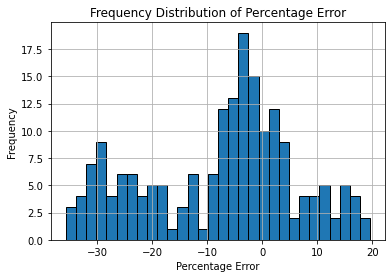

In [25]:
final_df['percerror'].hist(bins=30, edgecolor='black')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Percentage Error')
plt.show()

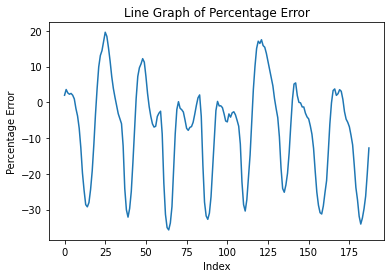

In [26]:
# Assuming 'test' is your DataFrame and 'percerror' is the column you want to plot
final_df['percerror'].plot(kind='line')
plt.xlabel('Index')
plt.ylabel('Percentage Error')
plt.title('Line Graph of Percentage Error')
plt.show()

## Using Facebook Prophet to do the forecasting

In [27]:
# %pip install prophet

In [28]:
'''
  >>> from prophet import Prophet
  >>> m = Prophet()
  >>> m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
  >>> future = m.make_future_dataframe(periods=365)
  >>> m.predict(future)


'''

"\n  >>> from prophet import Prophet\n  >>> m = Prophet()\n  >>> m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns\n  >>> future = m.make_future_dataframe(periods=365)\n  >>> m.predict(future)\n\n\n"

In [99]:
# face_df = df[['date_time', 'value']]
face_df = f_df[['period', 'value']]
face_df['period'] = pd.to_datetime(face_df['period'])

In [100]:
# rename the columns to 'ds' and 'y' for prophet
face_df = face_df.rename(columns={'period': 'ds', 'value': 'y'})

In [101]:
# doing a train test split
train = face_df.iloc[:int(len(face_df)*0.9), :]
train.reset_index(inplace=True)
test = face_df.iloc[int(len(face_df)*0.9):, :]
test.reset_index(inplace=True)


In [102]:
# using the prophet library to predict the values
m = Prophet()
# m.add_seasonality()
m.fit(train)

# m.summary()

00:55:04 - cmdstanpy - INFO - Chain [1] start processing
00:55:05 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
# predicting the values
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-05-27,322019.765718,257726.558608,361538.828849,322019.765718,322019.765718,-13626.447620,-13626.447620,-13626.447620,517.060871,517.060871,517.060871,-14143.508491,-14143.508491,-14143.508491,0.0,0.0,0.0,308393.318098
1,2019-05-28,322015.322625,261832.541408,363485.120276,322015.322625,322015.322625,-8408.597432,-8408.597432,-8408.597432,3132.423654,3132.423654,3132.423654,-11541.021087,-11541.021087,-11541.021087,0.0,0.0,0.0,313606.725193
2,2019-05-29,322010.879533,270937.210872,372185.868764,322010.879533,322010.879533,-2561.763922,-2561.763922,-2561.763922,6057.959000,6057.959000,6057.959000,-8619.722922,-8619.722922,-8619.722922,0.0,0.0,0.0,319449.115611
3,2019-05-30,322006.436440,273095.731302,374830.147266,322006.436440,322006.436440,2207.523313,2207.523313,2207.523313,7601.749449,7601.749449,7601.749449,-5394.226136,-5394.226136,-5394.226136,0.0,0.0,0.0,324213.959753
4,2019-05-31,322001.993347,280265.869318,377060.286947,322001.993347,322001.993347,5108.839851,5108.839851,5108.839851,6994.719843,6994.719843,6994.719843,-1885.879992,-1885.879992,-1885.879992,0.0,0.0,0.0,327110.833198


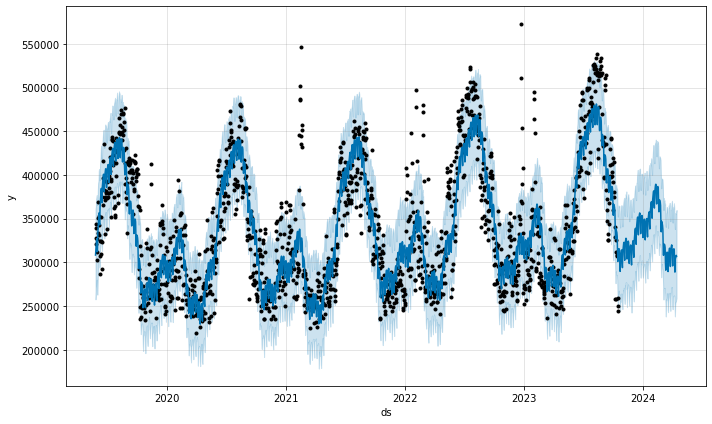

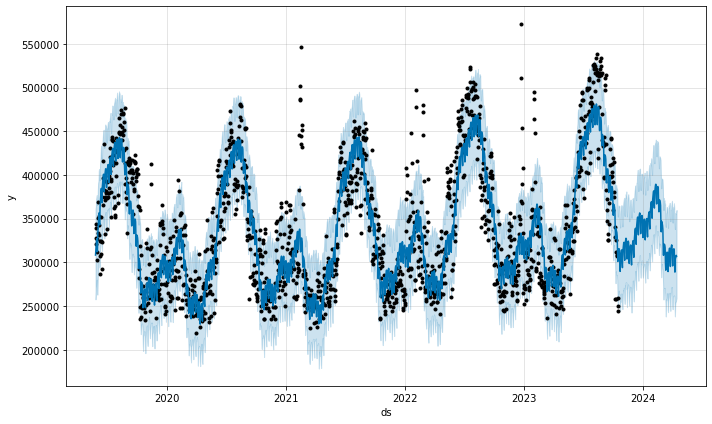

In [104]:
m.plot(forecast)

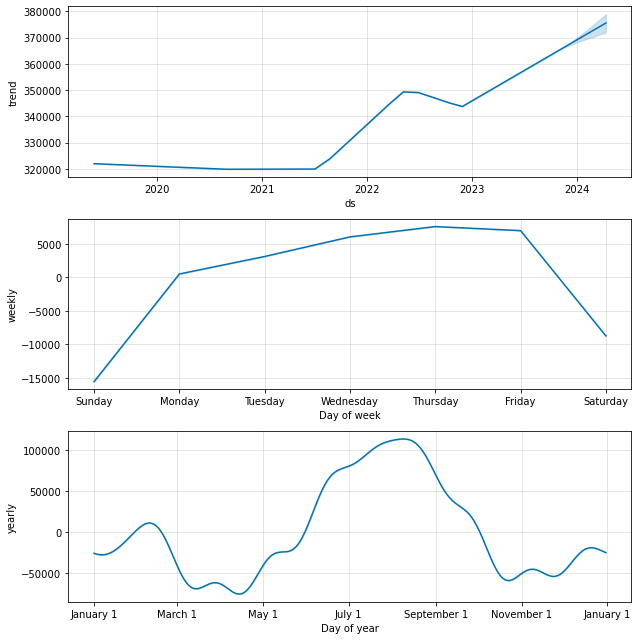

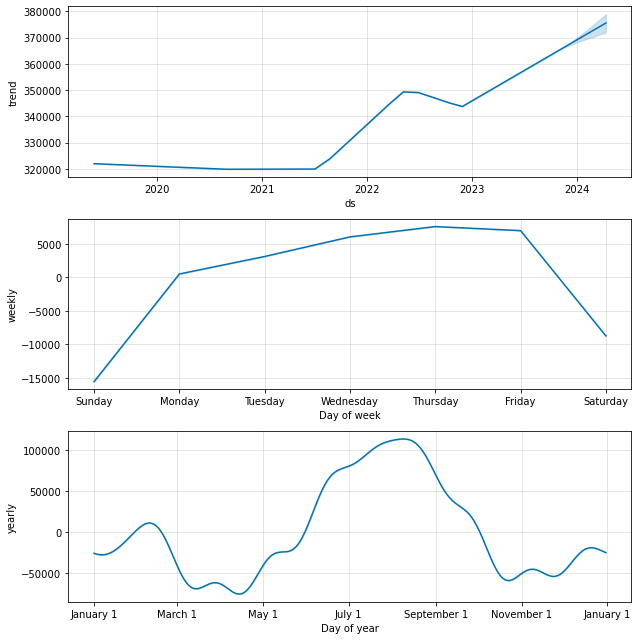

In [105]:
m.plot_components(forecast)

In [61]:
# face_df.reset_index(inplace=True)
# forecast.reset_index(inplace=True)
act_forecast = pd.concat([face_df, forecast[['yhat', 'yhat_lower', 'yhat_upper']]], axis = 1)
# act_forecast['y'] = act_forecast['y'].astype('float64')
# act_forecast.index = act_forecast['ds']
act_forecast.dropna(inplace=True)
# act_forecast.tail(5)

In [115]:
act_forecast = pd.DataFrame(
    {
        'ds': face_df['ds'],
        'y': face_df['y'],
        'yhat': forecast['yhat'],
        'yhat_lower': forecast['yhat_lower'],
        'yhat_upper': forecast['yhat_upper']
    }
)

In [119]:
act_forecast.index = act_forecast['ds']
act_forecast.drop(columns='ds', inplace=True)

In [120]:
act_forecast.tail()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2024-04-20,268585,303833.252202,251615.647392,355982.347980
2024-04-21,255028,305380.804376,255101.689680,356670.935226
2024-04-22,275427,307367.001688,255104.201145,355544.852171
2024-04-23,288458,308140.077927,257393.492682,358107.534140
2024-04-24,316612,306968.097774,258831.671370,359913.344721


In [108]:

# Assuming 'df' is your DataFrame and 'y' and 'yhat' are the columns

rmse = sqrt(mean_squared_error(act_forecast['y'], act_forecast['yhat']))
print('Root Mean Square Error:', rmse)

Root Mean Square Error: 41978.84595976289


In [121]:
# percentage change in actual and predicted values
act_forecast['perc_diff'] = ((act_forecast['y'] - act_forecast['yhat'])*100)/act_forecast['y']

In [122]:
np.average(act_forecast['perc_diff'])

-2.2948317125922677

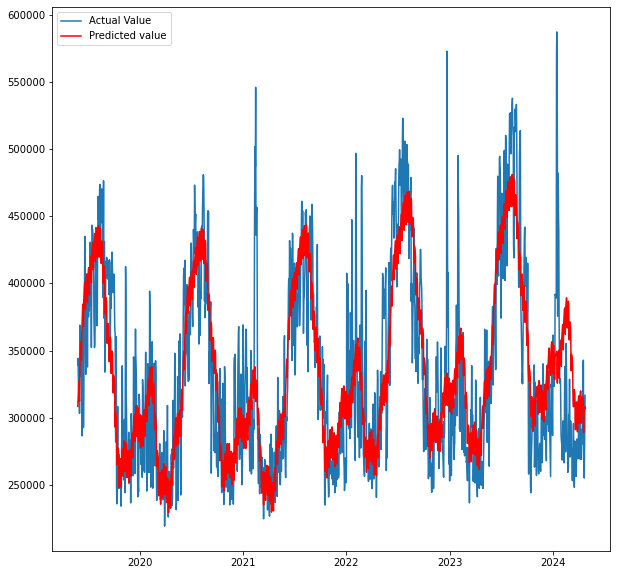

In [123]:
plt.figure(figsize=(10,10))
plt.plot(act_forecast['y'], label='Actual Value')
plt.plot(act_forecast['yhat'], label='Predicted value', color='red')
plt.legend()
plt.show()